**This is a visual representation of where old people are concentrated in the city of São Paulo.**

Shades of red represent where the percentage of old people is higher in São Paulo's residential zones.

Spreadsheet data and map shapefile from 2007, made publicly available by Metrô, state-owned public transportation company from São Paulo city, Brazil.

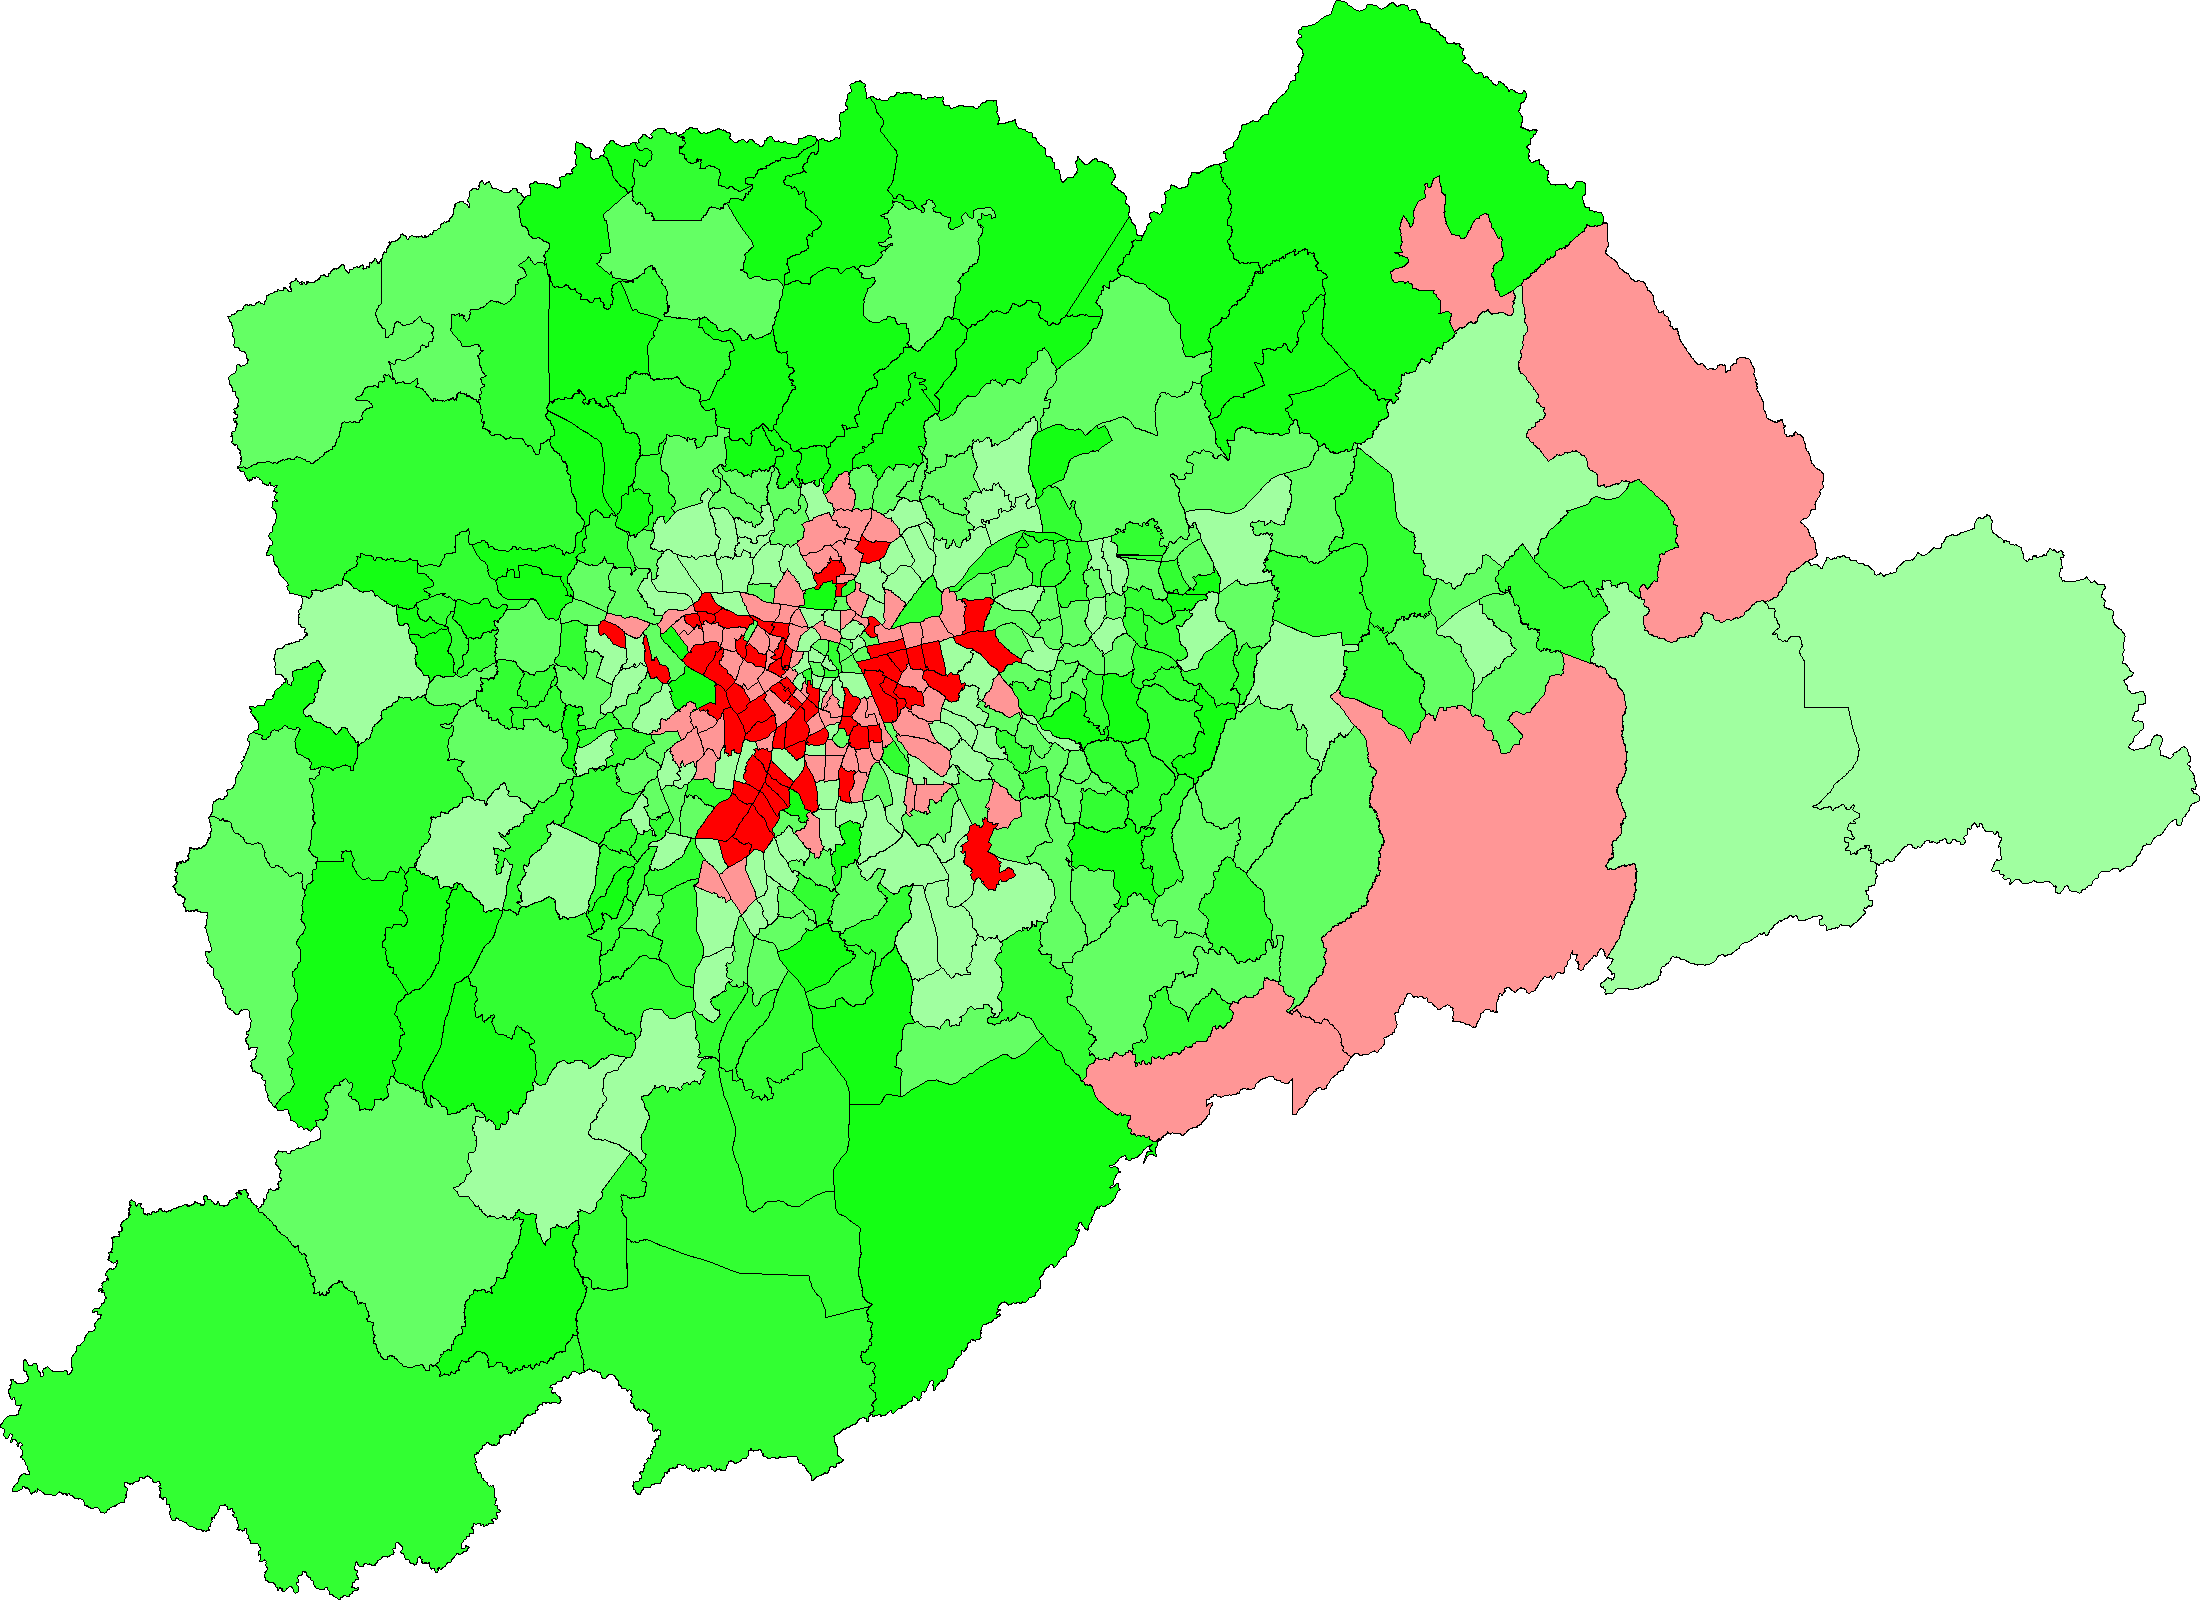

In [2]:
import shapefile
from PIL import Image, ImageDraw, ImageFont
from PIL.ImageDraw import Draw
import os
import io
import numpy
from pylab import *
from IPython.display import display
import matplotlib.pyplot as plt
from io import BytesIO
import random
from osgeo import ogr
import operator
from xlrd import open_workbook
from IPython.display import Image as ImageShow

# Read in a shapefile
shapeFilePath = r'Input/Zonas2007_022008_region.shp'
driver = ogr.GetDriverByName('ESRI Shapefile')
dataSource = driver.Open(shapeFilePath, 0) # 0 is read-only
layer = dataSource.GetLayer()
r = shapefile.Reader(shapeFilePath)

# Get data from XLS
book = open_workbook('Input/Dados_Gerais_por_Zona.xls',on_demand=True)
sheet = book.sheet_by_name('Tabela 2')

# Calculate the ratio of old people per total people
oldiesPerZoneRatio = []

for rownum in range(8,468):
    oldiesPerZoneRatio.append((int(sheet.col(0)[rownum].value), 0 if int(sheet.col(11)[rownum].value) == 0 else int(sheet.col(11)[rownum].value) / int(sheet.col(12)[rownum].value)))

# Definition of color per old people ratio
def getColorPerOldieRatio(oldiesRatio):
    if oldiesRatio > 0.25:
        return 'rgb(255,0,0)'
    elif oldiesRatio > 0.20:
        return 'rgb(255,150,150)'
    elif oldiesRatio > 0.15:
        return 'rgb(160,255,160)'
    elif oldiesRatio > 0.10:
        return 'rgb(100,255,100)'
    elif oldiesRatio > 0.05:
        return 'rgb(50,255,50)'
    else:
        return 'rgb(20,255,20)'   

# Get Color method (calling getColorPerOldieRatio for São Paulo and returning a gray color otherwise)
def getColor(feature):
    ratio = list(filter(lambda a: a[0] == int(feature.GetField("ZONA")), oldiesPerZoneRatio))[0][1]
    return getColorPerOldieRatio(ratio)

# Getting the centroid of a shape
def getCentroid(pxls):
    sumx = 0
    sumy = 0

    minx = 999999
    maxx = 0
    miny = 999999
    maxy = 0
    
    for x,y in pxls:
        sumx += x
        sumy += y
        if x < minx:
            minx = x
        if x > maxx:
            maxx = x
        if y < miny:
            miny = y
        if y > maxy:
            maxy = y
    
    x = sumx/len(pxls)
    y = sumy/len(pxls)
    
    medx = (minx + maxx) /2
    medy = (miny + maxy) /2
        
    return (((medx + x) /2)-30,(medy +y)/2)


# Plotting the map

# Geographic x & y distance
xdist = r.bbox[2] - r.bbox[0]
ydist = r.bbox[3] - r.bbox[1]

# Image width & height
iwidth = 2200
iheight = 1600

xratio = iwidth/xdist
yratio = iheight/ydist

pixels = []
img = Image.new("RGB", (iwidth, iheight), "white")
draw = ImageDraw.Draw(img)

shapecount = 0;

for s in r.shapes():
    pixels = []
    for x,y in s.points:
      px = int(iwidth - ((r.bbox[2] - x) * xratio))
      py = int((r.bbox[3] - y) * yratio)
      pixels.append((px,py))
    draw.polygon(pixels, outline="rgb(0, 0, 0)", fill=getColor(layer[shapecount]))
    f = ImageFont.load_default()
    # Uncomment the line below to see zone numbers
    #draw.text(getCentroid(pixels), str(int(layer[shapecount].GetField("ZONA"))), font=f, fill=0)
    shapecount +=1
    
# The fields per shape available in the shapefile are the following:
# 'ZONA', 'NOMEZONA', 'MUNICIPIO', 'NOMEMUNICI', 'AREA_HA'
    
img.save(r'tempImg.png')
i = ImageShow(filename=r'tempImg.png')
i